permutation_feature_importance.ipynb

by: Lloyd Fernandes (lloydf2@illinois.edu)

Project director: Richard Sowers

r-sowers@illinois.eduhttps://publish.illinois.edu/r-sowers/

Copyright 2019 University of Illinois Board of Trustees. All Rights Reserved. Licensed under the MIT license

In [ ]:
####Simple_workflow

In [1]:

import sys
sys.path.append('../src/')
sys.path.append('../data/')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from feature_eng import split_trajectories
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from model_functions import *
import seaborn as sns

In [2]:
df = pd.read_pickle('../data/block4_updated.pkl')
 
df.head()

lat        lon    speed  \
file_name id edge_id             time                                   
4_1       1  250699362_250699984 42.00  37.982746  23.732961  11.9046   
                                 42.04  37.982746  23.732963  11.8975   
                                 42.08  37.982747  23.732964  11.8919   
                                 42.12  37.982748  23.732965  11.8871   
                                 42.16  37.982748  23.732966  11.8831   

                                        lon_acc  lat_acc  type  traveled_d  \
file_name id edge_id             time                                        
4_1       1  250699362_250699984 42.00  -0.1145   0.0138  Taxi      182.37   
                                 42.04  -0.1007   0.0147  Taxi      182.37   
                                 42.08  -0.0918   0.0157  Taxi      182.37   
                                 42.12  -0.0869   0.0167  Taxi      182.37   
                                 42.16  -0.0784   0.0176  Taxi      182.37   

                                        avg_speed   bearing  \
file_name id edge_id             time                         
4_1       1  250699362_250699984 42.00   9.740748  1.570795   
                                 42.04   9.740748  0.168572   
                                 42.08   9.740748  0.168573   
                                 42.12   9.740748  1.570796   
                                 42.16   9.740748  0.328080   

                                        nearest_edge_start_node  ...  \
file_name id edge_id             time                            ...   
4_1       1  250699362_250699984 42.00                250699362  ...   
                                 42.04                250699362  ...   
                                 42.08                250699362  ...   
                                 42.12                250699362  ...   
                                 42.16                250699362  ...   

                                        vehicle_density  avg_surr_speed  \
file_name id edge_id             time                                     
4_1       1  250699362_250699984 42.00                7       10.464171   
                                 42.04                7       10.457843   
                                 42.08                7       10.452857   
                                 42.12                7       10.448586   
                                 42.16                7       10.444986   

                                        edge_bearing  acc_edge  acc_per_edge  \
file_name id edge_id             time                                          
4_1       1  250699362_250699984 42.00      -2.83013  0.113220      0.021953   
                                 42.04      -2.83013  0.100360      0.016867   
                                 42.08      -2.83013  0.092194      0.013188   
                                 42.12      -2.83013  0.087837      0.010734   
                                 42.16      -2.83013  0.080021      0.007273   

                                        xtrack_diff  xtrack_diff_sq  \
file_name id edge_id             time                                 
4_1       1  250699362_250699984 42.00          0.0             0.0   
                                 42.04          0.0             0.0   
                                 42.08          0.0             0.0   
                                 42.12          0.0             0.0   
                                 42.16          0.0             0.0   

                                        acc_edge_sq  acc_per_edge_sq  \
file_name id edge_id             time                                  
4_1       1  250699362_250699984 42.00     0.012819         0.000482   
                                 42.04     0.010072         0.000284   
                                 42.08     0.008500         0.000174   
                                 42.12     0.007715         0.000115   
                       

In [3]:
#initial parameters

agg_dict = {
            'xtrack_diff': ['mean','std'],
            'xtrack_dist': ['mean','std'],
            'avg_surr_speed': ['mean','std'],
            'vehicle_density':['mean','std'],
            'lanes':['mean'],
            'len':['mean'],
            'speed':['mean','std'],
            'speed_bool': ['count','sum'],
            'lat_acc': ['mean','std'],
            'lon_acc': ['mean','std']
            }

overlap = 0.3
min_movement_limit = 1
speed_limit = 0
k = 5

traj_lens = np.arange(50,250 ,step=50)

validation_ratio = 0.2
vehicle_density = 1


In [4]:
for i in range(0,1):
    traj_len = 50
    
    model_car_taxi = Pipeline([('scaler', StandardScaler()), ('gbm', GradientBoostingClassifier())])
    model_car_car = Pipeline([('scaler', StandardScaler()), ('gbm', GradientBoostingClassifier())])
    
    """ 
    Fit model to classify among cars and taxis. 
    1. Remove vehicles with length less than traj_len
    2. split trajectory to training and testing set
    3. get training and testing aggregates 
    4. fit the model
    """
    df_filtered_car_taxi = df.groupby(df.index.names[:-1]) \
            .filter(lambda grp: (len(grp) >= traj_len) )

    df_filtered_car_taxi['speed_bool'] = (df_filtered_car_taxi['speed']>speed_limit).astype(int)
    
    df_train_car_taxi,df_test_car_taxi = split_train_test(df_filtered_car_taxi,validation_ratio)

    #aggregate trajectories
    #to train models
    X_train_car_taxi,y_train_car_taxi = get_xy(df_train_car_taxi,overlap = overlap,traj_len = traj_len,agg_dict = agg_dict,outlier_limit = 0,balance = 'by_edge')
    #to pick better performing models
    X_test_car_taxi,y_test_car_taxi = get_xy(df_test_car_taxi,overlap = overlap,traj_len = traj_len,agg_dict = agg_dict)

    model_car_taxi.fit(X_train_car_taxi,y_train_car_taxi)
    
    accuracy,_ = voting_accuracy(X_test_car_taxi,y_test_car_taxi, model_car_taxi,predict_proba = True)
    print("voting accuracy Car vs Taxi: ",accuracy)
    
    """ 
    Fit model to classify among cars. 
    1. Select 50% cars and label them as Car_1
    2. follow steps 1-4 as above
    """
    
    df_car_car = df[df.type == 'Car'].copy()
    df_filtered_car_car = df_car_car.groupby(df_car_car.index.names[:-1]) \
            .filter(lambda grp: (len(grp) >= traj_len) )
    df_filtered_car_car['speed_bool'] = (df_filtered_car_car['speed']>speed_limit).astype(int)

    df_index = df_filtered_car_car.reset_index()[['file_name','id']].drop_duplicates()
    df_filtered_car_car.loc[df_filtered_car_car.reset_index(['edge_id', 'time'],drop = True).index.isin(df_index.sample(frac = 0.5).set_index(['file_name','id']).index),'type']='Car_1'

    df_train_car_car,df_test_car_car = split_train_test(df_filtered_car_car,validation_ratio)

    #to train models
    X_train_car_car,y_train_car_car = get_xy(df_train_car_car,overlap = overlap,traj_len = traj_len,agg_dict = agg_dict,outlier_limit = 0,balance = 'by_edge')
    #to pick better performing models
    X_test_car_car,y_test_car_car = get_xy(df_test_car_car,overlap = overlap,traj_len = traj_len,agg_dict = agg_dict)

    model_car_car.fit(X_train_car_car,y_train_car_car)
    accuracy,_ = voting_accuracy(X_test_car_car,y_test_car_car, model_car_car,predict_proba = True)
    print("voting accuracy Car vs Car: ",accuracy)
    print("\n")


voting accuracy Car vs Taxi:  0.6372881355932203
voting accuracy Car vs Car:  0.5043478260869565




In [5]:
#permutation feature importance
def permutation_importance(model,X_test, y_test,n_repeats=30, random_state=0):
    s = voting_accuracy(X_test,y_test,model,predict_proba = True)[0]
    feature_importance = {}
    X_test_wo_id = X_test.reset_index(drop = True).copy()
    for feature in X_test_wo_id.columns:
        s_k = 0
        
        for k in range(n_repeats):
            X_test_k = X_test_wo_id.copy()
            X_test_k[feature] = X_test_k[feature].sample(frac = 1).reset_index(drop = True)
            X_test_k.index = X_test.index
            s_k += voting_accuracy(X_test_k,y_test,model,predict_proba = True)[0]
             
        feature_importance[feature]=round((s - (s_k/n_repeats))*100,3)
              
    return feature_importance
        

In [9]:
feature_imp_car_taxi = permutation_importance(model_car_taxi,X_test_car_taxi,y_test_car_taxi,30)
feature_imp_car_car = permutation_importance(model_car_car,X_test_car_car,y_test_car_car,30)

<BarContainer object of 16 artists>

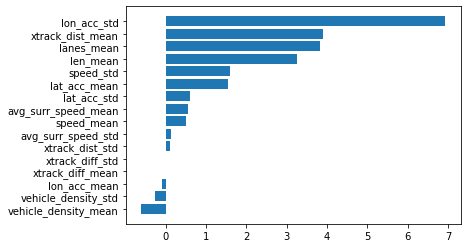

In [10]:
feature_imp_car_taxi = dict(sorted(feature_imp_car_taxi.items(), key=lambda item: item[1]))
plt.barh(list(feature_imp_car_taxi.keys()), list(feature_imp_car_taxi.values()), align='center')

<BarContainer object of 16 artists>

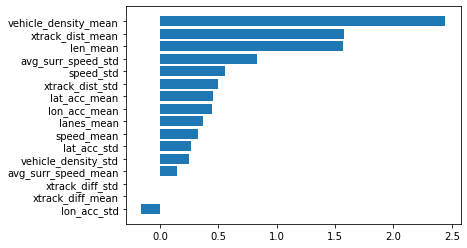

In [11]:
feature_imp_car_car = dict(sorted(feature_imp_car_car.items(), key=lambda item: item[1]))
plt.barh(list(feature_imp_car_car.keys()), list(feature_imp_car_car.values()), align='center')